In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [5]:
from prepocessing import DataProcessor

In [6]:
Processor = DataProcessor()
X_train, X_test, y_train, y_test = Processor.get_datas()

In [7]:
# Processor.train_info()
Processor.train_sample()

Esempio di dati nel dataframe di training
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783 

In [8]:
y_train.shape

(27455, 24)

In [9]:
def create_cnn(num_filters=32, kernel_size=(3, 3), dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(num_filters, kernel_size, activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters * 2, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Wrapping del modello in KerasClassifier per Scikit-learn
model = KerasClassifier(build_fn=create_cnn, verbose=0)

In [11]:
# Definire la griglia di parametri
param_dist = {
    'num_filters': [32, 64, 128],
    'kernel_size': [(3, 3), (5, 5)],
    'dropout_rate': [0.3, 0.5, 0.7],
    'epochs': [10, 20],
    'batch_size': [32, 64]
}

In [13]:
# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)
random_search_result = random_search.fit(X_train, y_train)

ValueError: Invalid parameter num_filters for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(num_filters=32)`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
# Migliori parametri trovati
print("Best params:", random_search_result.best_params_)
print("Best score:", random_search_result.best_score_)

In [13]:
# Addestramento del modello
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4698 - loss: 1.8088 - val_accuracy: 0.9487 - val_loss: 0.1811
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9821 - loss: 0.0858 - val_accuracy: 0.9989 - val_loss: 0.0157
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9992 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9957 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 8.8325e-04
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 5.7118e-04
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 1.0000 - loss: 4.1951e-04 - val_accuracy: 1.0000 - val_loss: 3.2579e-04
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 1.0000 - loss: 2.5091e-04 - val_accuracy: 1.0000 - val_loss: 2.3635e-04
Epoch 8/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9997 - loss: 0

In [14]:
# Valutazione sul test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Perdita sul test set: {test_loss:.4f}')
print(f'Accuratezza sul test set: {test_accuracy:.4f}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9090 - loss: 0.4512
Perdita sul test set: 0.4459
Accuratezza sul test set: 0.9103


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


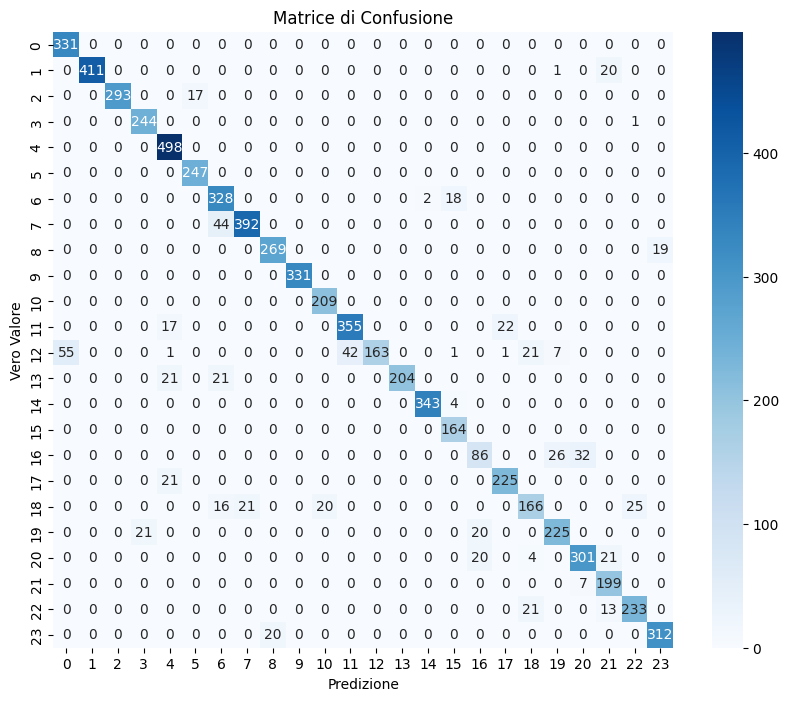

In [15]:

# Predizione sul test set
predictions = model.predict(X_test)

# Conversione delle predizioni in etichette
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Matrice di confusione
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice di Confusione')
plt.xlabel('Predizione')
plt.ylabel('Vero Valore')
plt.show()